In [47]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
sample_size=10000
seed=42

# Example on Discriminator and collider bias

The effect of discrimination on female earnings. The idea is that, even though females might be paid on par with their men coleagues, the discrimination leads to them being given lower level jobs. This example looks into how controlling for occupation actually leads to a worse causal model.

![female_occupation_dag.png](./female_occupation_dag.png)

In [5]:
# sample of about 50% females
female = tfp.distributions.Binomial(total_count=1, probs=0.5).sample(sample_size, seed=seed)
ability = tfp.distributions.Normal(loc=0.0, scale=1.0).sample(sample_size, seed)
discrimination = female
occupation =  1 + 2*ability + 0*female - 2*discrimination + tfp.distributions.Normal(loc=0.0, scale=1.0).sample(sample_size)
wage = 1 - 1*discrimination + 1*occupation + 2*ability +  tfp.distributions.Normal(loc=0.0, scale=1.0).sample(sample_size)

<AxesSubplot:ylabel='Count'>

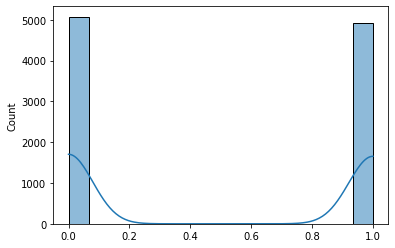

In [6]:
sns.histplot(female, kde='dist')

## Plot of occupation with discrimination

Text(0.5, 1.0, 'plot of occupation VS discrimination')

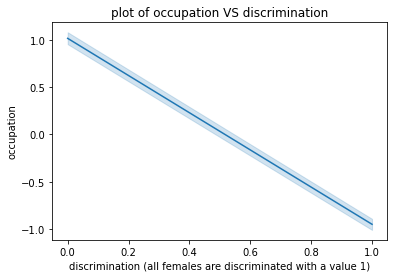

In [7]:
sns.lineplot(x=discrimination, y=occupation)
plt.xlabel('discrimination (all females are discriminated with a value 1)')
plt.ylabel('occupation')
plt.title('plot of occupation VS discrimination')

## Plot of wage with occupation and female

Text(0.5, 1.0, 'plot of wage VS discrimination')

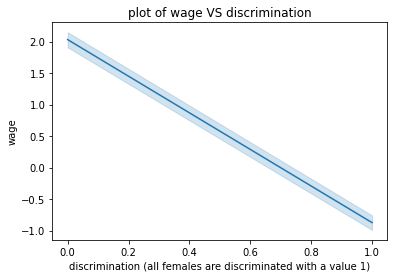

In [8]:
sns.lineplot(x=discrimination, y=wage)
plt.xlabel('discrimination (all females are discriminated with a value 1)')
plt.ylabel('wage')
plt.title('plot of wage VS discrimination')

Text(0.5, 1.0, 'plot of wage VS occupation')

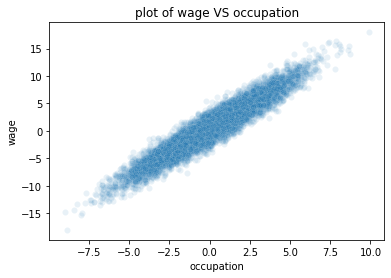

In [9]:
sns.scatterplot(x=occupation, y=wage, alpha=0.1)
plt.xlabel('occupation')
plt.ylabel('wage')
plt.title('plot of wage VS occupation')

## As the occupation increases the wage increases (higher values mean more lucrative occupations)

# We can run a simple linear model by conrolling for various IV and see which ones produce the actual values

In [10]:
help(tfp.glm.fit)

Help on function fit in module tensorflow_probability.python.glm.fisher_scoring:

fit(model_matrix, response, model, model_coefficients_start=None, predicted_linear_response_start=None, l2_regularizer=None, dispersion=None, offset=None, convergence_criteria_fn=None, learning_rate=None, fast_unsafe_numerics=True, maximum_iterations=None, l2_regularization_penalty_factor=None, name=None)
    Runs multiple Fisher scoring steps.
    
    Args:
      model_matrix: (Batch of) `float`-like, matrix-shaped `Tensor` where each row
        represents a sample's features.
      response: (Batch of) vector-shaped `Tensor` where each element represents a
        sample's observed response (to the corresponding row of features). Must
        have same `dtype` as `model_matrix`.
      model: `tfp.glm.ExponentialFamily`-like instance which implicitly
        characterizes a negative log-likelihood loss by specifying the
        distribuion's `mean`, `gradient_mean`, and `variance`.
      model_coeffici

In [11]:
female.shape, wage.shape

(TensorShape([10000]), TensorShape([10000]))

In [12]:
lm1 = tfp.glm.fit(model_matrix=tf.concat([tf.ones(sample_size)[..., np.newaxis], female[...,np.newaxis]], axis=-1), response=wage, model=tfp.glm.Normal())

In [13]:
lm1[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 2.0323012, -2.9069355], dtype=float32)>

In [14]:
female

<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 0., 0., ..., 0., 1., 1.], dtype=float32)>

In [15]:
lm2 = tfp.glm.fit(model_matrix=tf.concat([tf.ones(sample_size)[..., np.newaxis], female[..., np.newaxis], occupation[..., np.newaxis]], axis=-1), response=wage, model=tfp.glm.Normal())

In [16]:
lm2

[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.19749989, 0.6422597 , 1.8057615 ], dtype=float32)>,
 <tf.Tensor: shape=(10000,), dtype=float32, numpy=
 array([ -4.129424 ,   3.5859337,  -2.2013206, ...,  -2.5820336,
        -11.295872 ,  -2.2365944], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>]

In [17]:
lm3 = tfp.glm.fit(model_matrix=tf.concat([tf.ones(sample_size)[..., np.newaxis], female[..., np.newaxis], occupation[..., np.newaxis], ability[..., np.newaxis]], axis=-1), \
    response=wage, \
            l2_regularizer=None, \
        model=tfp.glm.Normal())

In [18]:
lm3

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.9737564 , -0.93121433,  1.0199646 ,  1.9721729 ], dtype=float32)>,
 <tf.Tensor: shape=(10000,), dtype=float32, numpy=
 array([ -3.317984 ,   2.616005 ,  -1.7150302, ...,  -1.6098175,
        -10.845293 ,  -3.1132314], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>]

## These are the same set of params displayed in the book

Intuitively: When you do not controll for anything `wage ~ female` then, to some extent, the variation in occupation confounds with the discrimination and cancels each other out (though the degree cannot be determined). But, when you do control for `occupation` you are, now, not accounting for the `discrimination` that results in `females` having occupations that are inferior to those gotten by men.

In [19]:
tf.zeros((1, 4), dtype=tf.float32)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [20]:
help( tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors, name=None)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    

In [21]:
dataset = tf.data.Dataset.from_tensor_slices(tensors=tf.concat([tf.ones(sample_size)[..., np.newaxis],
 female[..., np.newaxis], occupation[..., np.newaxis], ability[..., np.newaxis],
 wage[..., np.newaxis]], axis=-1))

In [22]:
sample_mat, sample_response = dataset.shuffle(5000).batch(100).map(lambda x: (x[:, :-1], x[:, -1])).take(1).get_single_element()

fitted_model = tfp.glm.fit(sample_mat, sample_response, model = tfp.glm.Normal())
fitted_model[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.7074036, -0.9763966,  1.0731202,  1.9032629], dtype=float32)>

In [23]:
all_model_coef = []
model_coeff_ = tf.zeros((4), dtype=tf.float32)
for model_matrix, response in dataset.shuffle(3000).batch(100).map(lambda x: (x[:, :-1], x[:, -1])):
    
    # print(response.shape)
    fitted_model = tfp.glm.fit(model_matrix, response, model = tfp.glm.Normal(), model_coefficients_start=model_coeff_)#, learning_rate=tf.constant([0.85], dtype=tf.float32))
    model_coeff_ = fitted_model[0]
    all_model_coef.append(model_coeff_)

model_coeff_

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.92990845, -0.5436157 ,  1.2036865 ,  1.6014394 ], dtype=float32)>

# Note:

This approach is not correct as for every batch it fits the best model. So, the intercepts are actually for the very last batch it received.

# Neural-Net ~ Linear regression approach:

A single layer nnet with a linear activation function is essentially the same as a linear regression. This, with an additional `tfp.layers.NMormal()` at the end should be able to compute the necessary parameters and uncertainities.

In [79]:
help(tfp.layers.IndependentNormal)

Help on class IndependentNormal in module tensorflow_probability.python.layers.distribution_layer:

class IndependentNormal(DistributionLambda)
 |  IndependentNormal(*args, **kwargs)
 |  
 |  An independent normal Keras layer.
 |  
 |  ### Example
 |  
 |  ```python
 |  tfd = tfp.distributions
 |  tfpl = tfp.layers
 |  tfk = tf.keras
 |  tfkl = tf.keras.layers
 |  
 |  # Create a stochastic encoder -- e.g., for use in a variational auto-encoder.
 |  input_shape = [28, 28, 1]
 |  encoded_shape = 2
 |  encoder = tfk.Sequential([
 |    tfkl.InputLayer(input_shape=input_shape),
 |    tfkl.Flatten(),
 |    tfkl.Dense(10, activation='relu'),
 |    tfkl.Dense(tfpl.IndependentNormal.params_size(encoded_shape)),
 |    tfpl.IndependentNormal(encoded_shape)
 |  ])
 |  ```
 |  
 |  Method resolution order:
 |      IndependentNormal
 |      DistributionLambda
 |      keras.layers.core.lambda_layer.Lambda
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      te

In [72]:
tf.keras.backend.clear_session()
input_fts = tf.keras.layers.Input((4), dtype=tf.float64)
# dense_linear = tf.keras.layers.Dense(4, activation=None)(input_fts)
output = tf.keras.layers.Dense(1, activation=None, use_bias=False)(input_fts)

output = tfp.layers.IndependentNormal()

model_lm = tf.keras.Model(inputs=[input_fts], outputs=output)

model_lm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_lm.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.9), loss='mse')

In [74]:
model_lm.fit(dataset.shuffle(3000).batch(100).map(lambda x: (x[:, :-1], x[:, -1])), epochs=100)

Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 2.0379
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9104
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2289
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 1.4731
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8145
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6210
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 1.5541
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 1.4804
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3080
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5181
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 2.1585
Epoch 12/100
100/100 [==============================] - 0s 2ms/step - loss: 1.1935
Epoch 13/100


<AxesSubplot:>

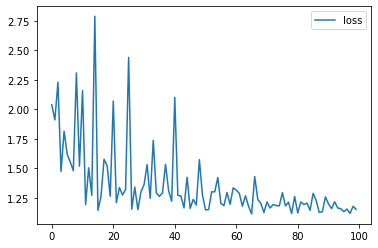

In [75]:
pd.DataFrame(model_lm.history.history).plot(kind='line')

In [77]:
model_lm.get_layer('dense').get_weights()[0]

array([[ 1.0083052],
       [-0.7721342],
       [ 0.9294625],
       [ 2.187428 ]], dtype=float32)

In [78]:
lm3[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.9737564 , -0.93121433,  1.0199646 ,  1.9721729 ], dtype=float32)>

# Achieving the same using tf_prob layers

In [80]:
help(tfp.layers.DenseVariational)

Help on class DenseVariational in module tensorflow_probability.python.layers.dense_variational_v2:

class DenseVariational(keras.engine.base_layer.Layer)
 |  DenseVariational(*args, **kwargs)
 |  
 |  Dense layer with random `kernel` and `bias`.
 |  
 |  This layer uses variational inference to fit a "surrogate" posterior to the
 |  distribution over both the `kernel` matrix and the `bias` terms which are
 |  otherwise used in a manner similar to `tf.keras.layers.Dense`.
 |  
 |  This layer fits the "weights posterior" according to the following generative
 |  process:
 |  
 |  ```none
 |  [K, b] ~ Prior()
 |  M = matmul(X, K) + b
 |  Y ~ Likelihood(M)
 |  ```
 |  
 |  Method resolution order:
 |      DenseVariational
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.autotrackable.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector


In [110]:
tf.keras.backend.clear_session()

model_lm2 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=None, use_bias=False),
  tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1)),
])


In [111]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [112]:
# Do inference.
model_lm2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)



In [113]:
model_lm2.fit(dataset.shuffle(300).batch(100).map(lambda x: ((x[:, :-1]), (x[:, -1]))),
 epochs=50, verbose=True)

Epoch 1/50
100/100 [==============================] - 1s 2ms/step - loss: 2.0428
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 1.4287
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4196
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4189
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4204
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4203
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4194
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4206
Epoch 9/50
100/100 [==============================] - 0s 3ms/step - loss: 1.4202
Epoch 10/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4216
Epoch 11/50
100/100 [==============================] - 0s 3ms/step - loss: 1.4205
Epoch 12/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4198
Epoch 13/50
100/100 [====

<AxesSubplot:>

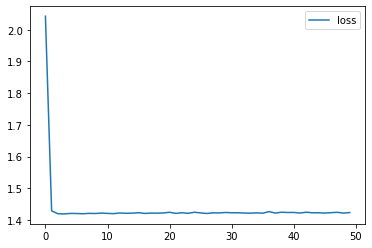

In [114]:
pd.DataFrame(model_lm2.history.history).plot(kind='line')

In [115]:
model_lm2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 distribution_lambda (Distri  ((None, 4),              0         
 butionLambda)                (None, 4))                         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [116]:
model_lm2.get_layer('dense').get_weights()[0]

array([[ 0.9664266 ,  0.96672857,  0.9667956 ,  0.9667429 ],
       [-0.86088794, -0.8613624 , -0.86147684, -0.8613787 ],
       [ 1.0174656 ,  1.0182341 ,  1.0183105 ,  1.0182246 ],
       [ 2.0136893 ,  2.0151396 ,  2.0153892 ,  2.015125  ]],
      dtype=float32)

In [117]:
lm3[0]  ##  Very close to the other model

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.9737564 , -0.93121433,  1.0199646 ,  1.9721729 ], dtype=float32)>

In [119]:
## THe average of these values should be treated as the actual param value

tf.reduce_mean(model_lm2.get_layer('dense').get_weights()[0], axis=1)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.96667343, -0.8612765 ,  1.0180588 ,  2.0148358 ], dtype=float32)>